# Robust Extensions and Hamiltonian Identification as Polynomial Optimization

This notebook uses multithreadin. Set  

    export JULIA_NUM_THREADS=100
   
before runing Julia

In [17]:
Threads.nthreads()

110

In [18]:
using LinearAlgebra
using QuantumOptics
using DynamicPolynomials
using TSSOS
using QuadGK
using JuMP
using Random
using NLopt

## Quantum system

In [19]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V_exact = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V_exact ./= norm(V_exact, Inf);

In [20]:
H0

3×3 Matrix{Float64}:
 0.0  0.0       0.0
 0.0  0.515916  0.0
 0.0  0.0       1.0

In [21]:
V_exact

3×3 Matrix{Float64}:
 0.0       0.707107  0.0
 0.707107  0.0       1.0
 0.0       1.0       0.0

In [22]:
# the unknown to be found
@polyvar z[1:2]

# its exact value
const z_exact = [V_exact[1, 2], V_exact[2, 3]]

V_known = [
    0 z[1] 0;
    z[1] 0 z[2];
    0 z[2] 0
]

3×3 Matrix{Term{true, Int64}}:
 0   z₁  0
 z₁  0   z₂
 0   z₂  0

## Utilities for working with Polynomials

In [23]:
function ∫(p::AbstractPolynomial, x::PolyVar, x_lower, x_upper)
    
    # get the index of the variable of integration
    ind_x = indexin([x], variables(p))[1]
        
    if isnothing(ind_x)
        # integration valuable is not found among vars
        return p * (x_upper - x_lower)
    end
    
    # get the indefinite integral
    int_p = sum(
        term * x * 1 // (exponents(term)[ind_x] + 1) for term in terms(p)
        init = 0 * x
    )
            
    # get the definite integral
    subs(int_p, x=>x_upper) - subs(int_p, x=>x_lower)
end

function ∫(M::AbstractMatrix, x::PolyVar, x_lower, x_upper)
   map(z -> ∫(z, x, x_lower, x_upper), M) 
end

function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

square_frobenius_norm (generic function with 1 method)

## Get the truncated Magnus expansion ($n=3$)

In [24]:
@polyvar x[1:3]
@polyvar t[1:3]

# final time
const T = 0.5

function u(t, x)
    # the polynomial shape for control
    sum(x[n] * t^(n - 1) for n = 1:length(x))
end

function A(t, x)
    #=
    The generator of motion entering the Magnus expansion
    =#
    (H0 + V_known * u(t, x)) / im
end

function commutator(a, b)
    a * b - b * a
end 

# get the partial sum of the Magnus expansion
A₁ = A(t[1], x)
A₂ = A(t[2], x)

Ω = ∫(A₁, t[1], 0, T);

# 2nd term in the Magnus expansion
Ω .+= 1//2 * ∫(∫(
    commutator(A₁, A₂), 
    t[2], 0, t[1]), 
    t[1], 0, T
);

# 3nd term in the Magnus expansion

A₃ = A(t[3], x)

Ω .+= 1//6 * ∫(∫(∫(
    commutator(A₁, commutator(A₂, A₃)) + commutator(commutator(A₁, A₂), A₃),
    t[3], 0, t[2]),
    t[2], 0, t[1]),
    t[1], 0, T
);

## Chebyshve polynomial approximation for $\exp_p(\Omega^{(n)}/2)$ with $n=3$ and $p=5$

In [25]:
using SpecialFunctions

"""
Chebyshev approximation for exp(Ω/2)
"""
function exp_chebyshev(Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, 0.5) * Tₙ₋₁ + 2 * besselj(1, 0.5) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, 0.5) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

Ω = convert(typeof(A₁), Ω)

exp½Ω = exp_chebyshev(Ω, 5);

### Old: Construct the polynomial $\tanh_p \frac{\Omega^{(n)}}{2}$ with $n=3$ and $p=5$

## Getting statistic for checking the performance of quantum control formulation as a polynomial optimization

In [26]:
function get_unitray(x::AbstractArray, V::Matrix)
    #=
    Get the unitary given the coefficients for the polynomial control
    =#
    basis = NLevelBasis(size(H0)[1])

    𝓗₀ = DenseOperator(basis, basis, H0)
    𝓥 = DenseOperator(basis, basis, V)

    H = LazySum([1., u(0, x)], [𝓗₀, 𝓥])
        
    function 𝓗(t, psi)
        H.factors[2] = u(t, x)
        return H
    end

    _, 𝓤 = timeevolution.schroedinger_dynamic([0, T], identityoperator(basis, basis), 𝓗)
    
    return Matrix(𝓤[2].data)
end


function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

local_minimize (generic function with 1 method)

In [27]:
@time begin
    
n_samples = 1000
Random.seed!(6292022)

# randomly generate the coefficients for the polynomial control 
# to determine z
try_x = -1 .+ 2 * rand(length(x) * n_samples)
try_x = reshape(try_x, (length(x), n_samples))

# The values of objective functions for exact value of parameter z
obj_z_exact = zeros(n_samples)

# The global minimum via TSSOS library
tssos_glob_obj_min = zeros(n_samples)

# difference between recovered and exact z
norm_diff_z = zeros(n_samples)
    
# Testing the accuracy of the Magnus expansion
norm_U_target_minus_expΩ_min_z = zeros(n_samples)
norm_U_target_minus_expΩ_z_exact = zeros(n_samples)

Threads.@threads for i=1:n_samples
    
    # target unitray
    U_target = get_unitray(try_x[:, i], V_exact)
    
    # get the polynomial objective function
    
    exp½Ω_x = subs(exp½Ω, x => try_x[:, i])
    obj = square_frobenius_norm(
        exp½Ω_x' *  U_target - exp½Ω_x
    )
    
    # save the value of objective function for exact x
    obj_z_exact[i] = obj(z_exact)
    
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj); QUIET = true, solution = true)
    
    previous_sol = sol
    previous_opt = opt
    
    while ~isnothing(sol)
        previous_sol = sol
        previous_opt = opt
            
        opt,sol,data = tssos_higher!(data; QUIET = true, solution = true)
    end
    
    tssos_glob_obj_min[i] = previous_opt
    min_z = previous_sol
        
    # refine the estimate by local minimization
    min_z = local_minimize(obj, min_z)
    
    norm_diff_z[i] = norm(min_z - z_exact)
    
    # Testing the accuracy of the Magnus expansion
    Ω_min_z = convert(Matrix{ComplexF64}, subs(Ω, x => try_x[:, i], z => min_z))
    norm_U_target_minus_expΩ_min_z[i] = norm(U_target - exp(Ω_min_z))
        
    Ω_z_exact = convert(Matrix{ComplexF64}, subs(Ω, x => try_x[:, i], z => z_exact))
    norm_U_target_minus_expΩ_z_exact[i] = norm(U_target - exp(Ω_z_exact))
end
    
end

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.90783315977245e-7
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 1.4687606272464676e-7
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 1.7403422038268354e-7
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 1.2840262927408728e-7
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
optimum = 9.390300376616867e-8
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
****

No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 9.365489834484146e-8
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 2.47046843648105e-7
optimum = 1.621205913930415e-7
optimum = 1.2029011965643172e-7
Global optimality certified!
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is lau

************************TSSOS************************
No higher TSSOS hierarchy!
TSSOS is launching...
optimum = 9.483941917063516e-8
optimum = 1.2917601408872447e-7
No higher TSSOS hierarchy!
optimum = 5.675302774585577e-8
optimum = 1.263886193986218e-7
optimum = 1.651192609247492e-7
optimum = 1.672904376425185e-7
************************TSSOS************************
optimum = 1.5263227511004494e-7
optimum = 6.263798814646333e-8
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
************************TSSOS************************
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 6.545889719157649e-8
Global optimality certified!
optimum = 1.2970300775435736e-7
Global optimality certified!
optimum = 2.0500824674721535e-7
Global optimality certified!
Global optimality certified!
Global optimality certified!
Global optimality certified!
TSSOS is launching...
Global optimality certified!
Global optimality certified!
TSSOS is launching...


************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.7248563624114523e-7
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 1.4132155785650707e-7
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 8.071509855560655e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************

optimum = 4.0216051202892456e-8
Global optimality certified!
************************TSSOS************************
************************TSSOS************************
No higher TSSOS hierarchy!
Global optimality certified!
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 6.412034729808939e-8
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 5.8402866538421675e-8
Global optimality certified!
optimum = 2.553547697399124e-7
optimum = 5.945555900409189e-8
Glob

No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.402434009647508e-7
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.8323793030683319e-7
Global optimality certified!
optimum = 1.2594627963788552e-7
Global optimality certified!
optimum = 6.238847370044832e-8
optimum = 1.483974695843787e-7
Global optima

optimum = 1.259001252216063e-7
optimum = 1.734127804519672e-7
No higher TSSOS hierarchy!
optimum = 1.2841756277486424e-7
Global optimality certified!
Global optimality certified!
optimum = 1.7874076724411415e-7
Global optimality certified!
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.4014270607579752e-7
optimum = 4.553342972432871e-8
Global optimality certified!
optimum = 6.697620958755472e-8
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.5920369625554874e-7
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hi

************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
optimum = 1.7626350607940588e-7
optimum = 1.4758825668171974e-7
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 2.000344379710917e-7
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
optimum = 1.6344517456997767e-7
optimum = 1.1987777515111442e-7
optimum = 6.759159732039059e-8
optimum = 6.399251875836184e-8
optimum = 5.9191136447023233e-8
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 1.282350446513246e-7
Global optimality certified!
Global optimality certified!
Global optimality certified!
************************TSSOS******************

optimum = 1.451475457347988e-7
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 6.264009598274548e-8
optimum = 2.068265656822415e-7
Global optimality certified!
Global optimality certified!
optimum = 2.3048571312458617e-7
Global optimality certified!
************************TSSOS************************
TSSOS is launching...
optimum = 1.1861250780486598e-7
Global optimality certified!
optimum = 1.1112010053626875e-7
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.302666855214442e-7
optimum = 1.0179907914264757e-7
No higher TSSOS hierarchy!
Global optimality certified!
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
optimum = 1.7737141625236207e-7
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
***********

No higher TSSOS hierarchy!
Global optimality certified!
TSSOS is launching...
TSSOS is launching...
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
optimum = 6.057061115908071e-8
TSSOS is launching...
optimum = 1.9655202205117696e-7
optimum = 2.5143714639816616e-7
Global optimality certified!
Global optimality certified!
TSSOS is launching...
Global optimality certified!
TSSOS is launching...
Global optimality certified!
No higher TSSOS hierarchy!
TSSOS is launching...
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 2.2545193859314643e-7
Global optimality certified!
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
Global optimality certified!
optimum = 6.034879826123889e-8
No higher TSSOS hierarchy!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is 

optimum = 5.0810162128667165e-8
Global optimality certified!
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
************************TSSOS************************
TSSOS is launching...
No higher TSSOS hierarchy!
optimum = 1.803162356675106e-7
Global optimality certified!
optimum = 1.1330953613024248e-7
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 1.245856357363543e-7
No higher TSSOS hierarchy!
optimum = 1.9624296469706965e-7
Global optimality certified!
Global optimality certified!
optimum = 9.344521453052118e-8
No higher TSSOS hierarchy!
Global optimality certified!
No higher TSSOS hierarchy!
optimum = 1.6670271480375285e-7
Global optimality certified!
optimum = 1.3847055548701594e-7
No higher TSSOS hierarchy!
Global optimality certif

## Saving results

## Analysis

In [28]:
using Plots
using LaTeXStrings

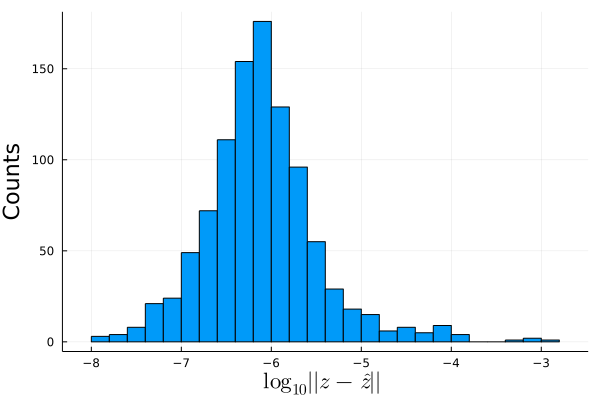

In [34]:
histogram(
    log10.(norm_diff_z), 
    label=nothing, 
    xlabel=L"\log_{10}||z - \hat{z}||", 
    ylabel="Counts",
    guidefontsize=15,
    #tickfontsize=15
)
#savefig("Fig_ZexactVsZrecovered.pdf")

### Actual global minimum vs global minimum estimate via MomentTools

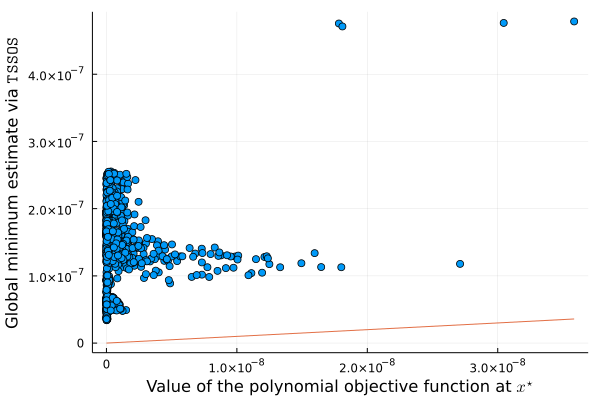

In [30]:
scatter(obj_z_exact, tssos_glob_obj_min, label=nothing)
lower = min(minimum(obj_z_exact), minimum(tssos_glob_obj_min))
higher = maximum(obj_z_exact)
plot!([lower, higher], [lower, higher], label=nothing)
xlabel!("Value of the polynomial objective function at " * L"x^{\star}")
ylabel!("Global minimum estimate via " * L"\texttt{TSSOS}")

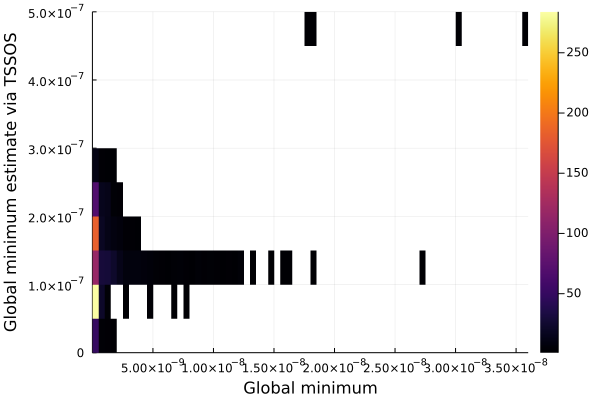

In [31]:
histogram2d(obj_z_exact, tssos_glob_obj_min)
xlabel!("Global minimum")
ylabel!("Global minimum estimate via TSSOS")

### Checking accuracy of the Magnus approximatiom

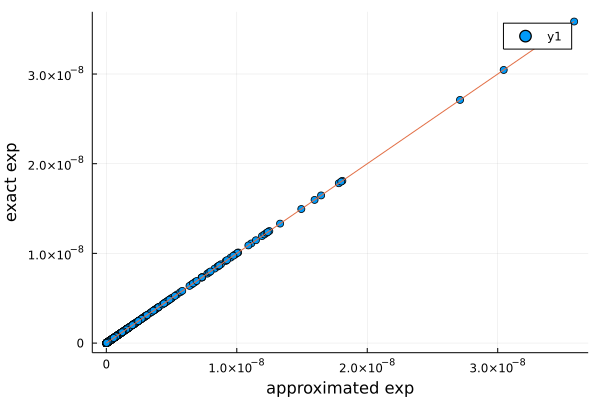

In [32]:
scatter(obj_z_exact, norm_U_target_minus_expΩ_min_z .^ 2)
lower = min(minimum(obj_z_exact), minimum(norm_U_target_minus_expΩ_min_z .^ 2))
higher = max(maximum(obj_z_exact), maximum(norm_U_target_minus_expΩ_min_z .^ 2))
plot!([lower, higher], [lower, higher], label=nothing)
xlabel!("approximated exp")
ylabel!("exact exp")